In [3]:
# python2
import pandas as pd
import numpy as np
import os
import itertools as it
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import gzip

In [4]:
with gzip.open('Beeradvocate.txt.gz', 'r') as f:
  rb_file = f.readlines()


data = []
row_out = []

for i in rb_file:
    row = i.decode('utf-8', errors = 'ignore')
    #print(row)
    if row == '\n':
      data.append(row_out)
      row_out = []
      continue
    row = row.split(":", 1)[1].rstrip()
    row_out.append(row)

In [5]:
data = pd.DataFrame(data)

data.columns = ['beer_name', 'beer_beerId', 'beer_brewer', 'beer_ABV', 'beer_style', 
                'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 
                'review_overall', 'review_time', 'review_profileName', 'review_text']


In [6]:
#### Subset original dataset for hw2

# Subset 4 columns: user name, beer name, overall score, review_time
data2 = data[['beer_name', 'review_profileName', 'review_overall','review_time']]
print('Original data size: %s' % str(data2.shape)) 

# Remove NA 
data2 = data2[pd.notnull(data2.beer_name)]
data2 = data2[pd.notnull(data2.review_profileName)]
data2 = data2[pd.notnull(data2.review_overall)]
print('After removing NAs: %s' % str(data2.shape)) 

# Drop duplicate (beer&user) pairs, keep the latest rating
data2['beer_user_pair'] = data2.beer_name + data2.review_profileName
data2 = data2.sort_values(by=['review_time'], ascending=False).drop_duplicates(subset=['beer_user_pair'])
print('After drop duplicate user-item pairs (only keep the latest score), data size: %s' % str(data2.shape))

Original data size: (1586614, 4)
After removing NAs: (1586614, 4)
After drop duplicate user-item pairs (only keep the latest score), data size: (1561732, 5)


In [7]:
# Take m users & n items
m, n = 1000, 100

# Take top 1000/33382 most frequent users
user_freqtable = data2.review_profileName.value_counts()
user_list = user_freqtable.keys()[:m].tolist()

# Take top 100/56855 most reviewed beer
beer_freqtable = data2.beer_name.value_counts()[:200]
beer_list = beer_freqtable.keys()[:n].tolist()

# Final sample size
subdata = data2[data2.beer_name.isin(beer_list)]
subdata = subdata[subdata.review_profileName.isin(user_list)]
print('Take the top %d users and top %d items as sample data. The Sample size is %s.' % (m,n,str(subdata.shape)))

Take the top 1000 users and top 100 items as sample data. The Sample size is (62278, 5).


# Collaborative Filtering

In [8]:
# Define function: convert input dataframe to rating matrix
def Rmat(users_dict, beers_dict, trainset):
    rmat = np.full([m, n], np.nan)
    for i in range(trainset.shape[0]):
        row, col = users_dict.get(trainset.review_profileName[i]), beers_dict.get(trainset.beer_name[i])
        rmat[row][col] = trainset.review_overall[i]
    return rmat

In [9]:
# Define function: Pearson distance
def Pearson(u, v):
    common_ind = pd.notnull(u) & pd.notnull(v)
    if sum(common_ind) == 0:
        return None
    else:
        u2, v2 = u[common_ind], v[common_ind]
        sim = sum(u2*v2)/((sum(u2**2)**(.5))*(sum(v2**2)**(.5)))
        return np.round(sim, 5)

In [10]:
# Define function: Predict rating
def PredRating(sim_mat, adj_rmat, i, j, k_neighbor, user_or_item):
    
    # find mu, similiarity_vector, adj_rating vector
    if user_or_item == 'user':
        mu = np.nanmean(train_rmat[i]) 
        ind1 = pd.notnull(adj_rmat[:,j])
        adj_r_vec = adj_rmat[:,j][ind1]
        sim_vec = sim_mat[i][ind1] 
    elif user_or_item == 'item':
        mu = np.nanmean(train_rmat[:,j])
        ind1 = pd.notnull(adj_rmat[i])
        adj_r_vec = adj_rmat[i][ind1]
        sim_vec = sim_mat[j][ind1]
    else:
        return 'wrong input: user or item'
    
    if sum(pd.isnull(sim_vec))>0:
        ind = pd.notnull(sim_vec)
        if len(ind) == 0:
            return None
        sim_vec, adj_r_vec = sim_vec[ind], adj_r_vec[ind]
    
    # take k nearest neighbor 
    if len(sim_vec) > k_neighbor:
        ind2 = np.argsort(sim_vec, kind='quicksort')[-k_neighbor:]
        sim_vec, adj_r_vec = sim_vec[ind2], adj_r_vec[ind2]
     
    # final rating
    numer, demon = sim_vec*adj_r_vec, np.absolute(sim_vec)
    pred_rating = mu + sum(numer)/sum(demon)

    return np.round(pred_rating, 5)

In [11]:
# Define error metric: RMSE
def RMSE(test_mat, pred_mat):
    test_mat, pred_mat = np.ndarray.flatten(test_mat), np.ndarray.flatten(pred_mat)
    ind_rmse = pd.notnull(test_mat) & pd.notnull(pred_mat)
    test_mat, pred_mat = test_mat[ind_rmse], pred_mat[ind_rmse]
    
    error = np.mean((test_mat - pred_mat)**2)**(.5)
    
    return np.round(error, 4)

In [12]:

# Split training & test set: should not have empty rows or columns
subdata2 = subdata[['beer_name','review_profileName','review_overall']]

train, test = train_test_split(subdata2, test_size=.2, random_state=1)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Create index dict; keys are user/beer names, values are corresponding row/col in rmat
m = len(user_list)
n = len(beer_list)
user_dict = {user_list[k]: k for k in range(m)}
beer_dict = {beer_list[k]: k for k in range(n)}

In [13]:
# Create train rating matrix: for both used- and item-based
train_rmat = Rmat(user_dict, beer_dict, train)

# Create test rating matrix: for both used- and item-based
test_rmat = Rmat(user_dict, beer_dict, test)

# Create prediction matrix - NaN
user = np.where(pd.notnull(test_rmat))[0] 
item = np.where(pd.notnull(test_rmat))[1] 

pred_rmat_user = np.full([m, n], np.nan)
pred_rmat_item = np.full([m, n], np.nan)

In [14]:
print(train.head(5))

               beer_name review_profileName review_overall
0               Pale Ale      Gambrinus1184            4.5
1        La Fin Du Monde             mwa423            4.5
2       World Wide Stout      MaltyGoodness            3.5
3   Arrogant Bastard Ale       ColoradoBobs            2.5
4              The Abyss             Chaney            4.5


In [15]:
print(test.head(5))

                              beer_name review_profileName review_overall
0   Old Rasputin Russian Imperial Stout          younger35              4
1          Stone Imperial Russian Stout             Beejay              4
2                    Orval Trappist Ale           dmamiano              4
3              Founders Breakfast Stout          UnionMade              5
4                               ApriHop            Goliath            3.5


In [16]:
train_rmat[:2,] # rating of user1 and user2 for all beers

array([[4.5, 4. , 4.5, 4. , 4. , 4.5, 3.5, 4. , 4. , 4. , 4. , 4.5, 4. ,
        nan, 4.5, nan, 3.5, 4. , 4.5, nan, 3.5, 4. , 5. , nan, 4.5, 4.5,
        3.5, 3.5, 4.5, 2. , nan, 5. , 4.5, 4. , 4.5, 4.5, 4. , 4.5, 3.5,
        4. , 4. , 3.5, nan, 3.5, 3.5, 3.5, nan, nan, 3.5, nan, 3. , 4. ,
        nan, 3.5, 3.5, 4. , 4.5, 4. , 3.5, 4.5, 3. , 4. , 4.5, 4. , 4.5,
        4. , 4. , 3.5, 3.5, 3. , 4. , 3.5, 4. , 4.5, nan, 4.5, 3.5, nan,
        4. , 3. , 4. , 4. , nan, 4.5, 3. , 3. , 3. , nan, 4. , 4. , 4. ,
        4. , 1. , nan, 4.5, 4. , 3.5, 4. , nan, nan],
       [4. , 4.5, 4.5, 4.5, 4. , 5. , 4.5, 4.5, 4. , 5. , nan, 5. , nan,
        4. , 3. , 4.5, nan, 5. , 5. , 4.5, 4. , 5. , 4.5, nan, 4. , 5. ,
        4. , 4. , 4. , nan, 4.5, 4.5, 2. , 3. , 4.5, 4.5, nan, 3.5, 3.5,
        nan, 5. , nan, nan, 4. , 4.5, 4. , 4. , 4.5, 4.5, nan, 4.5, 3.5,
        5. , 5. , nan, 5. , nan, 4.5, 3.5, nan, 4. , 4.5, 3.5, 3.5, 4.5,
        4. , 4.5, 4. , 4. , 3.5, 4. , 3.5, 5. , 4. , 3.5, 4. , 5. , na

***User based collaborative filtering***

In [17]:
# compute mean rating of each user
# mean_rating_user = {key: train.review_overall.loc[train['review_profileName'] == key].mean() for key in user_list}

# compute mean_adjusted rating of each user: subtract mean from ratings
adj_rmat_user = [train_rmat[0] - np.nanmean(train_rmat[0])]
for i in range(1,len(train_rmat)):
    adj_rmat_user = np.append(adj_rmat_user, [train_rmat[i] - np.nanmean(train_rmat[i])], axis=0)

In [18]:
# compute Pearson similiarity matrix 
sim_user = np.full([m, m], np.nan)

for u,v in it.combinations(range(len(user_list)), 2): 
    sim_user[u][v] = Pearson(adj_rmat_user[u], adj_rmat_user[v])
    sim_user[v][u] = sim_user[u][v]

C:\Users\821647\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\821647\AppData\Local\Continuum\anaconda2\lib\site-packages\numpy\core\fromnumeric.py:51: RuntimeWarning: invalid value encountered in rint
  return getattr(obj, method)(*args, **kwds)


In [19]:
# predict
k = 500
for ind in range(len(user)): 
    i, j = user[ind], item[ind]
    pred_rmat_user[i, j] = PredRating(sim_user, adj_rmat_user, i, j, k, 'user')

In [20]:
# calculate MSE
user_rmse = RMSE(test_rmat, pred_rmat_user)
print('User-based collaborative filtering error is %.4f' % (user_rmse))

User-based collaborative filtering error is 0.5319


***Item Based Collaborative Filtering***

In [21]:
# compute mean_adjusted rating vector of each item
adj_rmat_item = [train_rmat[:,0] - np.nanmean(train_rmat[:,0])]
for i in range(1,len(train_rmat[0])):
    adj_rmat_item = np.append(adj_rmat_item, [train_rmat[:,i] - np.nanmean(train_rmat[:,i])], axis=0)

adj_rmat_item = np.transpose(adj_rmat_item)

In [22]:
# compuete Pearson similiarity matrix 
sim_item = np.full([n, n], np.nan)
for u,v in it.combinations(range(len(beer_list)), 2): 
    sim_item[u][v] = Pearson(adj_rmat_item[u], adj_rmat_item[v])
    sim_item[v][u] = sim_item[u][v]

In [23]:
# predict 
k = 50
for ind in range(len(item)): 
    i, j = user[ind], item[ind]
    pred_rmat_item[i, j] = PredRating(sim_item, adj_rmat_item, i, j, k, 'item')

In [24]:
# calculate MSE
item_rmse = RMSE(test_rmat, pred_rmat_item)
print('Item-based collaborative filtering error is %.4f' % (item_rmse))

Item-based collaborative filtering error is 0.5493


# Tuning Parameters

In [25]:
# define function: get mu, similiarity_vector, adj_rating vector
def get_sim_adjr(sim_mat, adj_rmat, i, j, user_or_item):
    
    # find mu, similiarity_vector, adj_rating vector
    if user_or_item == 'user':
        mu = np.nanmean(train_rmat[i]) 
        ind1 = pd.notnull(adj_rmat[:,j])
        adj_r_vec = adj_rmat[:,j][ind1]
        sim_vec = sim_mat[i][ind1] 
    elif user_or_item == 'item':
        mu = np.nanmean(train_rmat[:,j])
        ind1 = pd.notnull(adj_rmat[i])
        adj_r_vec = adj_rmat[i][ind1]
        sim_vec = sim_mat[j][ind1]
    else:
        return 'wrong input: user or item'
    
    if sum(pd.isnull(sim_vec))>0:
        ind = pd.notnull(sim_vec)
        if len(ind) == 0:
            return None
        sim_vec, adj_r_vec = sim_vec[ind], adj_r_vec[ind]
    
    return [sim_vec, adj_r_vec, mu]

In [26]:
# define function: predict ratings based on similiarity & neighborhood size k
def get_pred(sim_vec, adj_r_vec, mu, k):
    # get k neighbors
    if len(sim_vec) > k:
        ind2 = np.argsort(sim_vec, kind='quicksort')[-k:]
        sim_vec, adj_r_vec = sim_vec[ind2], adj_r_vec[ind2]
     
    # predict 
    numer, demon = sim_vec*adj_r_vec, np.absolute(sim_vec)
    pred_rating = mu + sum(numer)/sum(demon)

    return np.round(pred_rating, 5)

***Tuning neighborhood size for user-based collaborative filtering***

In [27]:
user_k = [50, 100, 200, 225, 250, 275, 300, 325, 350, 375, 400, 450, 500, 550, 600]

# create prediction matrix
pred_rmat_user = {}
for k in user_k:
    pred_rmat_user[str(k)] = np.full([m, n], np.nan)

# predict
for ind in range(len(item)):
    i, j = user[ind], item[ind]
    sim, adjr, mu = get_sim_adjr(sim_user, adj_rmat_user, i, j, 'user') 

    for k in user_k:
        pred_rmat_user[str(k)][i, j] = get_pred(sim, adjr, mu, k)
        
# calculate error
rmse_user = []
for k in user_k:
    rmse_user.append(RMSE(test_rmat, pred_rmat_user[str(k)]))

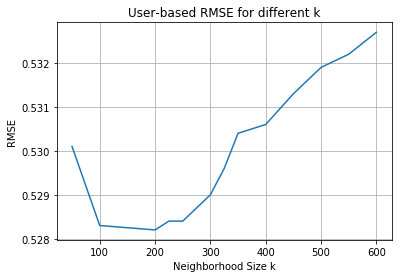

In [28]:
# Plot error
fig, ax = plt.subplots()
ax.plot(user_k, rmse_user)
ax.set(xlabel='Neighborhood Size k', ylabel='RMSE', title='User-based RMSE for different k')
ax.grid()

***Tuning neighborhood size for item-based collaborative filtering***

In [29]:
item_k = [5, 10, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 95, 100]

# create prediction matrix
pred_rmat_item = {}
for k in item_k:
    pred_rmat_item[str(k)] = np.full([m, n], np.nan)

# predict
for ind in range(len(item)):
    i, j = user[ind], item[ind]
    sim, adjr, mu = get_sim_adjr(sim_item, adj_rmat_item, i, j, 'item') 

    for k in item_k:
        pred_rmat_item[str(k)][i, j] = get_pred(sim, adjr, mu, k)
        
# calculate error
rmse_item = []
for k in item_k:
    rmse_item.append(RMSE(test_rmat, pred_rmat_item[str(k)]))

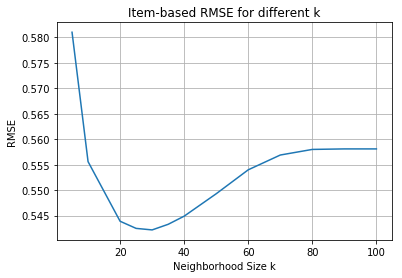

In [30]:
# Plot error
fig, ax = plt.subplots()
ax.plot(item_k, rmse_item)
ax.set(xlabel='Neighborhood Size k', ylabel='RMSE', title='Item-based RMSE for different k')
ax.grid()

# Evaluating Collaborative Filtering Approaches

4.1 Root Mean Square Error (RMSE)
4.2 Mean Absolute Error (MAE)
Methods: find the optimal neighborhood size k using RMSE and MAE and compare

4.3 Ranking based objective.
Methods: calculate the percentage of predicted top 10 beers in the true top 10 beer list for each user. (Using beers with explicit ratings. For example, if user i have rated 60 beers out of 100, then the true-top-10-beer-list is the top 10 out of 60. ignore the rest 40.)

***Root Mean Square Error (RMSE)***

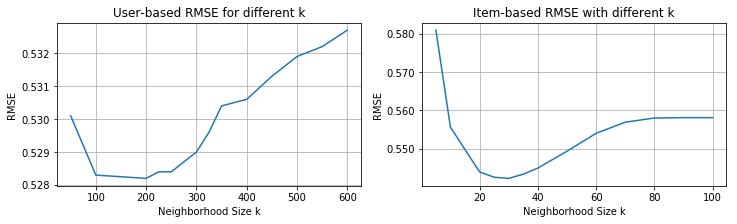

In [32]:
# Plot RMSE error, follow the previous section
fig = plt.figure(figsize=(12,3))

ax1 = fig.add_subplot(121)
ax1.plot(user_k, rmse_user)
ax1.set(xlabel='Neighborhood Size k', ylabel='RMSE', title='User-based RMSE for different k')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(item_k, rmse_item)
ax2.set(xlabel='Neighborhood Size k', ylabel='RMSE', title='Item-based RMSE with different k')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.grid()

plt.show()

***Mean Absolute Error (MAE)***

In [33]:
# Define error metric: MAE
def MAE(test_mat, pred_mat):
    test_mat, pred_mat = np.ndarray.flatten(test_mat), np.ndarray.flatten(pred_mat)
    ind_rmse = pd.notnull(test_mat) & pd.notnull(pred_mat)
    test_mat, pred_mat = test_mat[ind_rmse], pred_mat[ind_rmse]
    
    error = np.mean(np.absolute(test_mat - pred_mat))
    
    return np.round(error, 3)

In [34]:
# compute user-based MAE
mae_user = []
for k in user_k:
    mae_user.append(MAE(test_rmat, pred_rmat_user[str(k)]))

# compute item-based MAE
mae_item = []
for k in item_k:
    mae_item.append(MAE(test_rmat, pred_rmat_item[str(k)]))

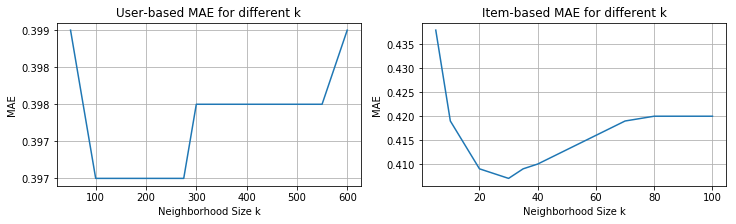

In [35]:
# Plot error
fig = plt.figure(figsize=(12,3))

ax1 = fig.add_subplot(121)
ax1.plot(user_k, mae_user)
ax1.set(xlabel='Neighborhood Size k', ylabel='MAE', title='User-based MAE for different k')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(item_k, mae_item)
ax2.set(xlabel='Neighborhood Size k', ylabel='MAE', title='Item-based MAE for different k')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.grid()

plt.show()